## Air Quality Anomaly Detection

This project aims to detect anomalies in air quality sensor data, focusing on unsupervised learning approaches.
My goal is to demonstrate practical skills in data cleaning, feature engineering, exploratory analysis, and the application of machine learning for anomaly detection, with a direct pipeline to an interactive Streamlit app.

This notebook provides a full workflow for detecting anomalies in air quality sensor data. It covers:
- Data loading & inspection
- Cleaning and feature engineering
- Exploratory Data Analysis (EDA)
- Unsupervised anomaly detection with Isolation Forest

All preprocessing and modeling utilities are modularized for code clarity and reusability.

In [21]:
# =====================================
# Air Quality Anomaly Detection Project
# =====================================
# Description: End-to-end workflow for detecting anomalies in air quality data.
# =====================================

import sys
import os
import pandas as pd

# Ensure project modules are accessible
sys.path.append(os.path.abspath("../utils"))

# Import custom preprocessing and modeling utilities
from preprocess import ( # type: ignore
    clean_data,
    extract_time_features,
    scale_features,
    run_pca,
    run_isolation_forest
)


## 1. Load Raw Data

The dataset is loaded with proper encoding and decimal settings to ensure numerical values are parsed correctly.

In [22]:
# Load the raw air quality dataset
filepath = "../data/AirQualityUCI.csv"

df_raw = pd.read_csv(filepath, sep=";", encoding="latin1", decimal=",")

# Note: The raw dataset uses ',' as a decimal separator

## 2. Raw Data Inspection

Before cleaning, let's explore the dataset structure, identify missing values, and spot potential formatting issues. This will inform our preprocessing choices.


In [23]:
# Preview the first few rows
display(df_raw.head())

# Overview of columns, datatypes, and non-null counts
df_raw.info()

# Check for missing values and empty columns
missing_summary = df_raw.isnull().sum()
display(missing_summary[missing_summary > 0].sort_values(ascending=False))

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9471 entries, 0 to 9470
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           9357 non-null   object 
 1   Time           9357 non-null   object 
 2   CO(GT)         9357 non-null   float64
 3   PT08.S1(CO)    9357 non-null   float64
 4   NMHC(GT)       9357 non-null   float64
 5   C6H6(GT)       9357 non-null   float64
 6   PT08.S2(NMHC)  9357 non-null   float64
 7   NOx(GT)        9357 non-null   float64
 8   PT08.S3(NOx)   9357 non-null   float64
 9   NO2(GT)        9357 non-null   float64
 10  PT08.S4(NO2)   9357 non-null   float64
 11  PT08.S5(O3)    9357 non-null   float64
 12  T              9357 non-null   float64
 13  RH             9357 non-null   float64
 14  AH             9357 non-null   float64
 15  Unnamed: 15    0 non-null      float64
 16  Unnamed: 16    0 non-null      float64
dtypes: float64(15), object(2)
memory usage: 1.2+ MB


Unnamed: 16      9471
Unnamed: 15      9471
NO2(GT)           114
AH                114
RH                114
T                 114
PT08.S5(O3)       114
PT08.S4(NO2)      114
Date              114
Time              114
NOx(GT)           114
PT08.S2(NMHC)     114
C6H6(GT)          114
NMHC(GT)          114
PT08.S1(CO)       114
CO(GT)            114
PT08.S3(NOx)      114
dtype: int64

**Observation:**  
- Some columns have all or mostly missing values.
- Certain columns are non-numeric and require conversion.

## 3. Data Cleaning

A custom cleaning function has been applied to:
- Drop constant or empty columns
- Handle missing values (e.g., forward/backward fill)
- Standardize column datatypes

This prepares the data for robust feature engineering and modeling.


In [24]:
# Clean the dataset using our custom utility function
df_clean = clean_data(df_raw)

# Show changes after cleaning
print("Before cleaning:", df_raw.shape)
print("After cleaning:", df_clean.shape)

# Display a summary of remaining missing values (if any)
display(df_clean.isnull().sum().sort_values(ascending=False).head())


Original: 9471
After dropping unnamed/empty columns: 9471
After replacing -200 with NaN: 9471
After converting numeric columns: 9471
After dropping NMHC(GT): 9471
After dropping rows with too many NaNs: 8991
After imputing remaining NaNs: 8991
Before cleaning: (9471, 17)
After cleaning: (8991, 14)


Date           0
Time           0
CO(GT)         0
PT08.S1(CO)    0
C6H6(GT)       0
dtype: int64

## 4. Feature Engineering

Additional features (such as hour of day and day of week) have been created to capture temporal trends in air quality that may help detect anomalies.


In [25]:
# Extract relevant time-based features (hour, day of week, etc.)
df_feat = extract_time_features(df_clean)

print(df_feat[['Datetime', 'Hour', 'Month']].head())

# Show the new feature columns
display(df_feat.head())

# Optional: Highlight new columns
print("New feature columns:", set(df_feat.columns) - set(df_clean.columns))


             Datetime  Hour  Month
0 2004-03-10 18:00:00    18      3
1 2004-03-10 19:00:00    19      3
2 2004-03-10 20:00:00    20      3
3 2004-03-10 21:00:00    21      3
4 2004-03-10 22:00:00    22      3


,Date,Time,CO(GT),PT08.S1(CO),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime,Hour,Month
0,10/03/2004,18:00:00,2.6,1360.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,2004-03-10 18:00:00,18,3
1,10/03/2004,19:00:00,2.0,1292.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,2004-03-10 19:00:00,19,3
2,10/03/2004,20:00:00,2.2,1402.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,2004-03-10 20:00:00,20,3
3,10/03/2004,21:00:00,2.2,1376.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,2004-03-10 21:00:00,21,3
4,10/03/2004,22:00:00,1.6,1272.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,2004-03-10 22:00:00,22,3


New feature columns: {'Datetime', 'Hour', 'Month'}


## 5. Exploratory Data Analysis (EDA)

Pollutant trends and feature relationships have been visualised to identify patterns, seasonality, and possible anomalies in the data.

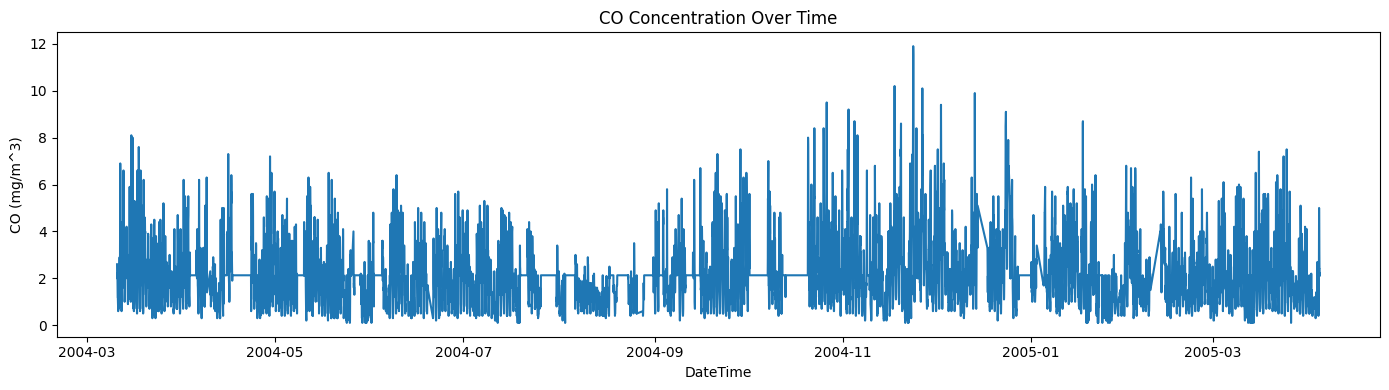

In [26]:
import matplotlib.pyplot as plt

# Plot a key pollutant over time
plt.figure(figsize=(14, 4))
plt.plot(df_feat['Datetime'], df_feat['CO(GT)'])
plt.xlabel('DateTime')
plt.ylabel('CO (mg/m^3)')
plt.title('CO Concentration Over Time')
plt.tight_layout()
plt.show()



The plot above shows the CO (carbon monoxide) concentration recorded by sensors over time.

There is clear temporal variability, with certain periods exhibiting frequent and sharp peaks.

These peaks may correspond to unusual pollution events, instrument errors, or local environmental changes.

Identifying and investigating such spikes is crucial for understanding air quality dynamics and for reliable anomaly detection.

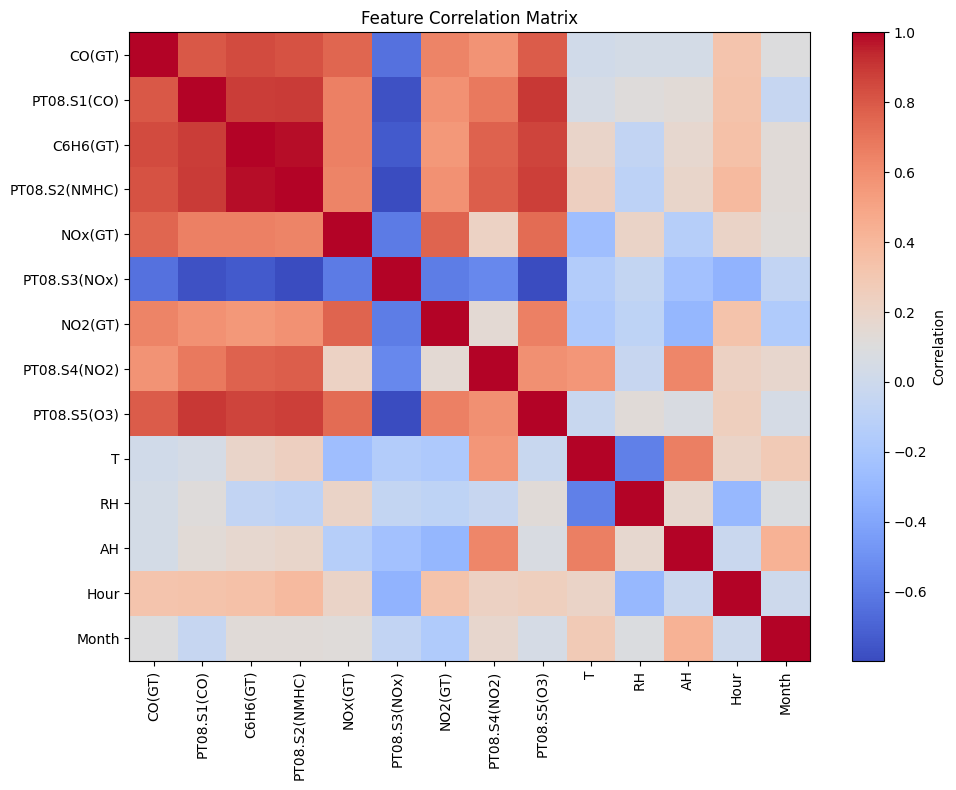

In [27]:
# Correlation matrix (numeric columns only)
numeric_cols = df_feat.select_dtypes(include='number').columns
corr = df_feat[numeric_cols].corr()
plt.figure(figsize=(10, 8))
plt.imshow(corr, cmap='coolwarm', aspect='auto')
plt.colorbar(label="Correlation")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.columns)), corr.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()


The correlation matrix above reveals relationships between all numeric features in the dataset.

As expected, several pollutant measures (e.g., CO(GT), C6H6(GT), PT08.S1(CO)) show strong positive correlations, suggesting shared sources or similar behavior in the urban environment.

Negative correlations are observed for some sensor pairs, such as between NOx(GT) and PT08.S3(NOx).

Understanding these relationships helps guide feature selection and interpretation of the model’s results.

## 6. Anomaly Detection with Isolation Forest

The dimensionality of the data is reduced by using PCA and applying Isolation Forest, which is well-suited for unsupervised outlier detection in high-dimensional datasets.

In [28]:
# 1. Scale features for PCA and anomaly detection
X_scaled = scale_features(df_feat)

print("X_scaled type:", type(X_scaled))
print("X_scaled shape:", getattr(X_scaled, "shape", None))

# 2. Reduce dimensionality with PCA
X_pca, pca_model = run_pca(X_scaled)

# 3. Apply Isolation Forest for anomaly detection
anomaly_scores, anomaly_labels, iso_forest_model = run_isolation_forest(X_pca)
df_feat['anomaly'] = anomaly_labels

# Attach anomaly labels for visualization
df_feat['anomaly'] = anomaly_labels


X_scaled type: <class 'pandas.core.frame.DataFrame'>
X_scaled shape: (8991, 14)


**Why these methods?**  
- PCA helps reduce noise and redundancy in correlated sensor data.
- Isolation Forest is robust to outliers and does not assume a particular data distribution.


## 7. Results and Interpretation

Anomalies are visualized as red 'x' marks. These points may correspond to sensor malfunctions or real pollution events.

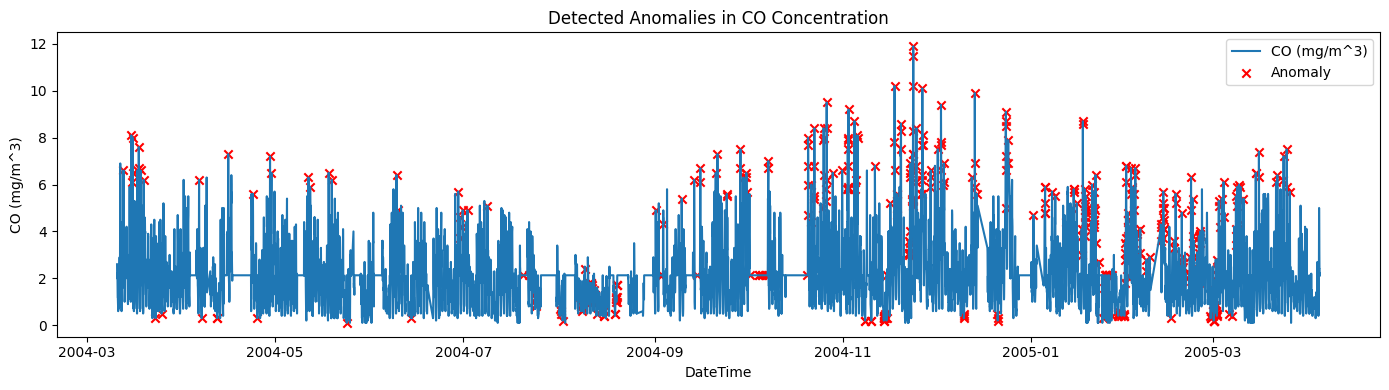

Total anomalies detected: 450


In [29]:
# Plot anomalies over time
plt.figure(figsize=(14, 4))
plt.plot(df_feat['Datetime'], df_feat['CO(GT)'], label='CO (mg/m^3)')
plt.scatter(
    df_feat.loc[df_feat['anomaly'] == -1, 'Datetime'],
    df_feat.loc[df_feat['anomaly'] == -1, 'CO(GT)'],
    color='red', label='Anomaly', marker='x'
)
plt.xlabel('DateTime')
plt.ylabel('CO (mg/m^3)')
plt.title('Detected Anomalies in CO Concentration')
plt.legend()
plt.tight_layout()
plt.show()

# Summary statistics
n_anomalies = (df_feat['anomaly'] == -1).sum()
print(f"Total anomalies detected: {n_anomalies}")

**Next steps:**  
- Validate anomalies with domain experts or external events.

## 8. Export Results for Application

The cleaned, labeled data and trained models have been exported for use in the interactive dashboard.

In [30]:
os.makedirs("../models/", exist_ok=True)

# Save results for use in the Streamlit app
df_feat.to_csv("../data/air_quality_processed.csv", index=False)

# (Optional) Save models if needed
import joblib

if 'pca_model' in locals():
	joblib.dump(pca_model, "../models/pca_model.joblib")
else:
	print("pca_model is not defined. Please run the PCA cell first.")

if 'iso_forest_model' in locals():
	joblib.dump(iso_forest_model, "../models/isoforest_model.joblib")
else:
	print("iso_forest_model is not defined. Please run the Isolation Forest cell first.")

### Reflection

Through this analysis, I reinforced my skills in data preprocessing, visualization, and unsupervised modeling.

The pipeline can be adapted for other sensor datasets, and deploying it in a Streamlit dashboard allows for further exploration and sharing of results.

Future work could include incorporating weather data or testing alternative anomaly detection algorithms.